### 1. Authors and  e-mail contact:
<ul>
    <li>Isaac Neri Gomez Sarmiento (isaacneri.gs@gmail.com)</li>
    <li>Deniz Soysal (deniz-soysal@hotmail.com)</li>
    <li>Stéphane Voyer-Boutet (SVoyer@gmail.com)</li>
    <li>Florian Philippe (florian.philippe.47@gmail.com)</li>
    </ul>
<b>Note:</b> <p> This is our final project for the course Introduction to Machine Learning (GIF-4101) at Laval University, taken in the automn session 2019. Some code for this project was taken from our Homework 4 of the same course. Some parts of the code and/or the results are in French.</p> <br>

### 2. Description:
The main goal is to classify if a patient has pneumonia from a X-Ray image of his/her chest using Convolutional Neural Networks (CNN) implemented with the Pytorch library. The dataset was obtained from Kaggle at https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia. 

<img src="CHEST_X_RAY.png" width="40%">


We used a transfer learning approach because of the following reasons:
<ol>
    <li>Training step doesn't take too much time</li>
    <li>Accuracy is usually higher when using a pre-trained model.</li>
    <li>It's simplier to implement than building a CNN from scratch.</li>
</ol>
We used and compared different architectures to know which best performed on the classification task.  
<ul>
    <li>VGG-16</li>
    <li>ResNet-101</li>
    <li>DenseNet-161</li>
</ul>

We used different image sizes such as:
<ul>
    <li>128x128 px</li>
    <li>256x256 px</li>
    <li>512x512 px</li>
</ul>

We also used different learning rates such as :
<ul>
    <li>0.001</li>
    <li>0.01</li>
    <li>0.1</li>
    <li>1</li>
    <li>10</li>
</ul>


    
### 3. Highlights:
<ul>
    <li>We obtained the best results using ResNet-101, with an image size of 256x256 px and a learning rate of 0.01:</li>
    <ul>
        <li>We got an accuracy for the test set of 89.62%</li>
        <li>We got an accuracy for the training set of 92.31%</li>
        <li>We got an accuracy for the validation set of 83.80%</li>
    </ul>
    <li>The confusion matrix of the test data with the best model is the following:</li> <!--vv [[106, 28], [16, 274]]-->
    <img src="CONFUSION_MATRIX.PNG" width="30%">
    <br>
    <li> This means that from all 424 chest x-ray images of the test data:</li>
    <ul>
        <li>106 were true negatives (they had no pneumonia and the algorithm classified them correctly)</li>
        <li>274 were true positives (they had pneumonia and the algorithm classified them correctly)</li>
        <li>16 were false negatives (they had pneumonia and the algorithm classified them incorrectly)</li>
        <li>28 were false positives (they had no pneumonia and the algorithm classified them incorrectly)</li>
    </ul>  
</ul>


### 4. Some remarks:

Some further improvements that could be made to this project:
<ul>
    <li>Preprocessing the gray-scale x-ray images maybe by increasing the contrast using histogram equalization or highlighting edges by using a high-pass filter</li>
    <li>Balancing data using a data augmentation approach</li>
    <li>Computing not only accuracy, but also precision, recall and F1-score </li>
    <li> Computing a ROC curve for the different models.</li>
    <li>Saving the best model's weights and biases so we can use it for inference when deploying our model</li>

</ul>

# 0. Verifying GPU
We used Google Colab because of the high speed GPU

In [0]:
!nvidia-smi

Tue Dec 17 05:12:05 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    38W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 1. Importing libraries

In [ ]:
import cv2 #Computer vision library that we'll use to read, resize and turn to grayscale our images.
import os #This allow us to interact with the operating system.This library will help us read multiple images from a certain directory. 
import time #We'll use the time module, to know how much time it takes for training for each epoch
import numpy #This allow us to work with vectors and matrices (images)
from sklearn.utils import shuffle #This allow us to shuffle our dataset

from matplotlib import rcParams 
rcParams['figure.figsize'] = (9.0, 7.0) #Setting the width and height in inches of graphs
from matplotlib import pyplot #This will help us plotting 


import torch #Importing torch library, which is a machine learning library
import torch.nn as nn #This allow us to use some classes and functions to build  neural network architectures
from torch.optim import SGD #This allow us to use the Stochastic Gradient Descent (SGD) algorithm to find the set of weights that miniminizes the loss function
from torch.utils.data import Dataset, DataLoader #Dataset stores the samples and their corresponding labels. DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

from torchvision.models import vgg16 #vgg16 Convolutional Neural Network (CNN)
from torchvision.models import resnet101 #resnet101 Convolutional Neural Network (CNN)
from torchvision.models import densenet161 #densenet161 Convolutional Neural Network (CNN)


torch.manual_seed(0) #This is to get reproducible random numbers


# 2. Defining functions

In [0]:
def compute_accuracy(model, dataloader, device='cpu'):
    """This function computes the accuracy of the trained model on a particular dataset (either train, validation or test) 
    *Input:
        -model:Trained model
        -dataloader: Wraps an iterable around the Dataset to enable easy access to the samples
        -device: Computing using CPU or GPU. CPU is the default
    
    *Output: 
        -Accuracy
    """
    
    training_before = model.training #True if it the model was in training mode
    model.eval() #Setting model to be in evaluation mode. Certain functionalities that are specific for training such as drop out (i.e desactivating some neurons in a layer) are deactivated.
    all_predictions = [] #Array that stores predicted labels
    all_targets = [] #Array that stores the actual labels
    
    for i_batch, batch in enumerate(dataloader):
        images, targets = batch #Batch is a sample to work through before updating the internal model parameters.
        images = images.to(device) #Sending images to the chosen device (either CPU or GPU)
        targets = targets.to(device) #Sending actual labels to the chosen device (either CPU or GPU)
        with torch.no_grad(): #Stop computing new gradients for updating internal model parameters
            predictions = model(images) #Entering the images to the model to classify them
        all_predictions.append(predictions.cpu().numpy()) #Appending predictions to a list
        all_targets.append(targets.cpu().numpy()) #Appending targets (actual labels) to a list

    if all_predictions[0].shape[-1] > 1: #If predictions have more than 1 dimension (i.e 2 or more channels)
        predictions_numpy = numpy.concatenate(all_predictions, axis=0)
        predictions_numpy = predictions_numpy.argmax(axis=1) #Choosing between all channels which is the one with the highest probability (the chosen channel is the predicted class)
        targets_numpy = numpy.concatenate(all_targets, axis=0)
    else: #If predictions are just 1 dimension
        predictions_numpy = numpy.concatenate(all_predictions).squeeze(-1)
        targets_numpy = numpy.concatenate(all_targets)
        predictions_numpy[predictions_numpy >= 0.5] = 1.0 #If probability is greater or equal than 0.5, then the instance belongs to class 1
        predictions_numpy[predictions_numpy < 0.5] = 0.0 #If the probability is less than 0.5, then the instance belongs to class 0

    if training_before: #If the model was in training mode before, then set it again to training mode after computing labels
        model.train()

    return (predictions_numpy == targets_numpy).mean() #Computing accuracy

def compute_confusion_matrix(model, dataloader, device='cuda'):
    """This function computes the confusion matrix of a binary classifier.
    This allows us to know how many instances were correctly labeled as positive and negative
    as well as false positives (which are in fact negative, but they were classified as positive) and false negative
    (which are in fact positive, but they were classified as negative).
    *Input:
        -model:Trained model
        -dataloader: Wraps an iterable around the Dataset to enable easy access to the samples
        -device: Computing using CPU or GPU. CPU is the default
        
    *Ouput:
        -Confussion matrix"""
    
    #Same code as the function that computes accuracy...
    training_before = model.training
    model.eval()
    all_predictions = []
    all_targets = []
    
    for i_batch, batch in enumerate(dataloader):
        images, targets = batch
        images = images.to(device)
        targets = targets.to(device)
        with torch.no_grad():
            predictions = model(images)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    if all_predictions[0].shape[-1] > 1:
        predictions_numpy = numpy.concatenate(all_predictions, axis=0)
        predictions_numpy = predictions_numpy.argmax(axis=1)
        targets_numpy = numpy.concatenate(all_targets, axis=0)
    else:
        predictions_numpy = numpy.concatenate(all_predictions).squeeze(-1)
        targets_numpy = numpy.concatenate(all_targets)
        predictions_numpy[predictions_numpy >= 0.5] = 1.0
        predictions_numpy[predictions_numpy < 0.5] = 0.0

    if training_before:
        model.train()
    #...from this point on, the code is different from the function that computes accuracy
    
    negatif = sum(predictions_numpy[targets_numpy==0]==0) #Number of instances correctly classified as negative
    faux_positif = sum(predictions_numpy[targets_numpy==0]==1) # Number of false positives
    faux_negatif = sum(predictions_numpy[targets_numpy==1]==0) # Number of false negatives
    positif = sum(predictions_numpy[targets_numpy==1]==1) #Number of instances correctly classified as positive

    matrix = [[negatif, faux_positif],[faux_negatif, positif]] #Confusion matrix
    return matrix


In [0]:
def train(model, train_set, test_set, nb_epoch, learning_rate):
    """
    This function trains our model with the given dataset.
    *Input:
        -model: The chosen neural network architecture
        -train_set: The training set of images
        -test_set: The test set of images
        -nb_epoch: Number of epochs or the number of passes of the entire training dataset the ML algorithm will complete.
        -learning_rate: This determines the step size at each iteration, while moving towards a minimum of a loss function.
    *Output:
        -A list with the accuracy obtained in each epoch.
    """
  
    device = "cuda" #Definig where we want the training to be done (gpu in this case)

    # Training parameters:
    momentum = 0.9 # Increases training speed and accuracy, by accumulating the gradient of the past steps to determine the direction to go.
    batch_size = 32 #Number of training samples to work through before the model’s internal parameters are updated.

    # Creating the training and test dataloader (wraps an iterable around the Dataset to enable easy access to the samples)
    train_loader = DataLoader(train_set, batch_size=batch_size)
    test_loader = DataLoader(test_set, batch_size=batch_size)

    # Transfering our model to the chosen device (gpu)
    model.to(device)

    # Instantiating the loss function cross entropy
    criterion = nn.CrossEntropyLoss()

    # Instantiating the optimization algorithm SGD (Stochastic Gradient Descent)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    # Setting the model in training mode
    model.train()

    test_acc_list = [] #List that will contain the test accuracy in each epoch
    loss_list = [] #List that will contain the loss value in each epoch

    for i_epoch in range(nb_epoch): #Iterating over all epochs

        start_time, train_losses = time.time(), [] 
        for i_batch, batch in enumerate(train_loader): #Iterating over all batches
            images, targets = batch #A batch is a subset of the training set that can be split into images and targets

            images = images.to(device) #Transfering our images to the chosen device (gpu)
            targets = targets.to(device) #Transfering our target values to the chosen device (gpu)

            # Setting gradients to zero: 
            #We need to set the gradients to zero before starting to do backpropragation because PyTorch 
            #accumulates the gradients on subsequent backward passes (https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            optimizer.zero_grad()

     
            predictions = model.forward(images) #Passing our images in parallel through the neural net in order to get a vector of predictions whose size is the sime as the batchsize
            loss = criterion(predictions, targets) #Computing the loss function values

            loss.backward() #Computing the gradient of the loss function with respect to the weights
            optimizer.step() #Updates the weights with the new computed gradients

            train_losses.append(loss.item()) #.item() function returns the value of the tensor as a standard Python number. We append it to a list.
            
        # Computing the average loss of the epoch
        print(' [-] epoch {:4}/{:}, train loss {:.6f} in {:.2f}s'.format(
            i_epoch + 1, nb_epoch, numpy.mean(train_losses), time.time() - start_time))
        
        #Computing average accuracy of the epoch
        test_acc = compute_accuracy(model, test_loader, device) 
        print(' [-] test acc. {:.6f}%'.format(test_acc * 100))
        
        test_acc_list.append(test_acc) #Appending test accuracy for each epoch to a list
        loss_list.append(numpy.mean(train_losses)) #Appending loss value for each epoch to a list

    # Prints the last final test accuracy
    test_acc = compute_accuracy(model, test_loader, device)
    print(' [-] test acc. {:.6f}%'.format(test_acc * 100))

    #Prints the loss list
    print(loss_list) 

    return test_acc_list

# 3. Defining classes

## 3.1 Class for importing dataset and creating labels

In [0]:
class pneumoniaDataset(Dataset):
    """
    This class imports the chest x-ray dataset
    """
    
    def __init__(self,path, size):
        """
        This method initializes the class attributes.
        *Input:
            -self: This refers to an object that belongs to the class pneumoniaDataset
            -path: The path where images are stored
            -size: The size we want to resize our images (square images)
        """
        super().__init__() #This is to be able to use methods and attributes in our class pneumoniaDataset inherited from the Pytorch class Dataset
        self.path=path #Initializing the path were images are stored
        self.size=size #Initializing the image size
        self.data=[] #Initialzing a list where we'll store both our images and target
        self.targets=[] #Initializing a list where we'll store our targets
     
        images=[] #List where we'll store our images
        
        for file_name in os.listdir(self.path+"/NORMAL"):
            #Reading our images and converting to grayscale
            img=cv2.imread(os.path.join(self.path+"/NORMAL", file_name), cv2.IMREAD_GRAYSCALE)
            #Resizing our images
            img=cv2.resize(img, (self.size,self.size))
            #Normalizing our images (instead of having values from 0 to 255, they will have values from 0 to 1)
            img=(img-numpy.min(img))/(numpy.max(img)-numpy.min(img))
            #Reshaping images to (number of channels, size, size)
            img=numpy.reshape(img, (1,numpy.shape(img)[0],numpy.shape(img)[0]))
            #Converting to a Pytorch tensor
            img=torch.from_numpy(img)
            #Setting the pytorch tensor type to "FloatTensor"
            img=img.type("torch.FloatTensor")
            
            #If the image is succesfully read and pre-processed then append to image list
            if img is not None:
                images.append(img)
        #Appending 0's to images read from the NORMAL directory (those who don't have pneumonia)      
        k=len(images) 
        for i in range(k):
            self.targets.append(0)
            
        #Same code as before, but we are now reading images from the pneumonia folder    
        for file_name in os.listdir(self.path+"/PNEUMONIA"):
            img=cv2.imread(os.path.join(self.path+"/PNEUMONIA", file_name), cv2.IMREAD_GRAYSCALE)
            img=cv2.resize(img, (self.size,self.size)) #Resizing
            img=(img-numpy.min(img))/(numpy.max(img)-numpy.min(img))
            img=numpy.reshape(img, (1,numpy.shape(img)[0],numpy.shape(img)[0]))
            img=torch.from_numpy(img)
            img=img.type("torch.FloatTensor")
            if img is not None:
                images.append(img)
        
        #Appending 1's to images read from the PNEUMONIA directory (those who don't have pneumonia)
        n=len(images)-k
        for i in range(n):
            self.targets.append(1)
        
        #Shuffling images and targets
        images, self.targets = shuffle(images, self.targets, random_state=20) 
            
        #Appending to the list data the images and the targets (both as pytorch tensors)
        for i in range(len(images)):
            self.data.append([images[i],torch.from_numpy(numpy.array(self.targets[i])).type("torch.ByteTensor")])
                
    def __getitem__(self, index):
        """
        This method allows us to get an item from the data set (image and label)
        *Input:
            -self: This refers to an object that belongs to the class pneumoniaDataset
            -index: The index of the dataset item we want to access.
        *Output:
            -An image and its corresponding label
        """
        X=self.data[index][0]
        y=self.targets[index]
    
        return X,y
    
    def __len__(self):
        """
        This method returns the number of items in the dataset
        """
        return len(self.targets)

## 3.2 Classes for defining pretrained models

In [0]:
class Pneumonia_vgg16(nn.Module):
    """
    This class defines a vgg16 pretrained model for a binary classification
    """

    def __init__(self, pretrained=True):
        """
        This method initializes the pretrained model
        """
        super().__init__() #This is to be able to use methods and attributes in our class Pneumonia_vgg16 inherited from the Pytorch class nn.Module

        self.model = vgg16(pretrained = True) #Initializing our model to be a pretrained vgg16


        for name, param in self.model.named_parameters(): #Looping through all parameters to look for the classifier layer
            if "classifier" in name:
                param.requires_grad = True #We want only the classifier layer to change its weights and biases with the computation of gradients
            else:
                param.requires_grad = False #Other layers won't change its parameters. This is called freezing layers.
        
        #Modifying last layer, so it's a binary classification (out_features=2). We leave in_features=4096, because that's how vgg16 architecture is built.         
        self.model.classifier[-1] = nn.Linear(in_features=4096, out_features=2) 
        #Telling pytorch that the input images will have only 1 channel (grayscale images), we'll use 64 3x3 convolution filters.
        #Stride=(height=1,width=1). Stride is how many pixels the filter will move at each step when doing the convolution over the image
        #Padding=(height=1,width=1). Padding means how many extra pixels are added to each side of the image before doing a convolution with the filter.
        #We have to remember that the convolution operation is just a pairwise multiplication of each pixel of the filter and each pixel of the image,
        #at the end you add all up and the result will be a new pixel correspoding to the filtered image. 
        self.model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) 

    def forward(self, x):
        """
        This method is for doing a forward pass of the data through the neural network
        """

        x = self.model.forward(x)
        return x

class Pneumonia_resnet101(nn.Module):
    """
    This class defines a resnet101 pretrained model for a binary classification
    """

    def __init__(self, pretrained=False):
        """
        This method initializes the pretrained model
        """
        super().__init__() #This is to be able to use methods and attributes in our class Pneumonia_resnet101 inherited from the Pytorch class nn.Module

        self.model = resnet101(pretrained = True) #Initializing our model to be a pretrained resnet101

        #Setting the first layer of the CNN to receive a grayscale image (1 channel), use 64 filters of 7x7
        #Stride=(height=2, width=2). Stride is how many pixels the filter will move at each step when doing the convolution over the image
        #Padding=(height=3,width=3). Padding means how many extra pixels are added to each side of the image before doing a convolution with the filter.
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        #Modifying the last layer so it's a binary classification (out_features=2). We leave in_features=2048, because that's how resnet101 architecture is built.
        self.model.fc = nn.Linear(in_features=2048, out_features=2)

        for name, param in self.model.named_parameters(): #Looping through all parameters to look for the "fc" or fully connected layer.
            
            if "fc" in name: 
                param.requires_grad = True #We want only the fc layer to change its weights and biases with the computation of gradients
            else:
                param.requires_grad = False #Other layers won't change its parameters. This is called freezing layers.

    def forward(self, x):
        """
        This method is for doing a forward pass of the data through the neural network
        """
        x = self.model.forward(x)
        return x

    def detailler(self): #Sanity check to know which layers are "frozen"
        for name, param in self.model.named_parameters():
            print("name ", name, "requires_grad", param.requires_grad, "grad", param.grad)

class Pneumonia_densenet161(nn.Module):

    def __init__(self, pretrained=False):
        super().__init__() #This is to be able to use methods and attributes in our class densenet161 inherited from the Pytorch class nn.Module

        self.model = densenet161(pretrained = True) #Initializing our model to be a pretrained densenet161
        
        #Setting the first layer of the CNN to receive a grayscale image (1 channel), use 96 filters of 7x7
        #Stride=(height=2, width=2). Stride is how many pixels the filter will move at each step when doing the convolution over the image
        #Padding=(height=3,width=3). Padding means how many extra pixels are added to each side of the image before doing a convolution with the filter.
        #Bias=False means b=0
        self.model.features.conv0 =  nn.Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        #Modifying the last layer so it's a binary classification (out_features=2). We leave in_features=2208, because that's how densenet161 architecture is built.
        #Bias=True means we are letting the algorithm learn b
        self.model.classifier = nn.Linear(in_features=2208, out_features=2, bias=True)

    def forward(self, x):
        """
        This method is for doing a forward pass of the data through the neural network
        """
        x = self.model.forward(x)
        return x

# 4. Visualizing some instances of the training, test and validation datasets.

In [0]:
train_set=pneumoniaDataset("train", 100) #Creating a training dataset of images with size 100x100 for visualization
n=train_set.__len__() #Getting the number of data from the training set

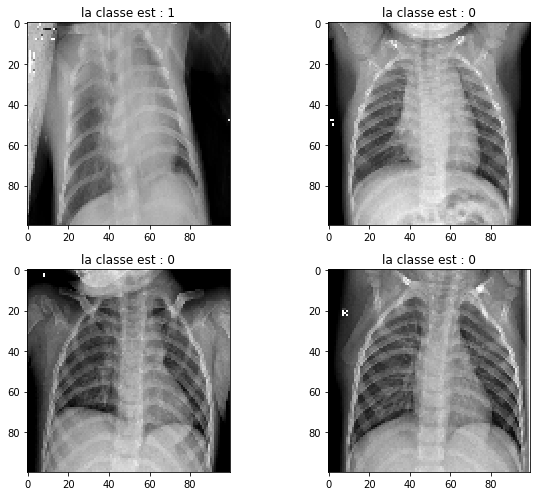

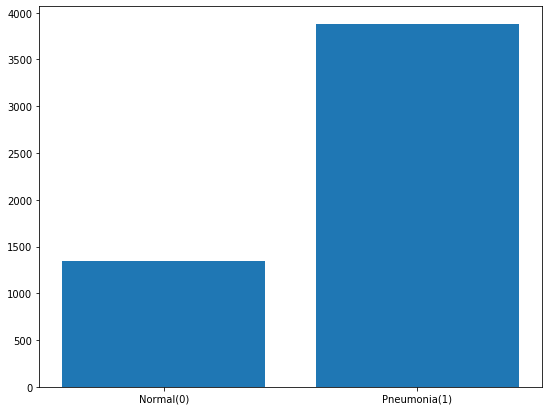

In [0]:
#In th following code we'll show 4 random examples of the x-ray images from the training set
fig, subfigs = pyplot.subplots(2, 2, tight_layout=True) #We'll create a 2x2 plot
for subfig in subfigs.reshape(-1):
   
    #Choosing a random image
    index = numpy.random.randint(0,n )
    data,targets=train_set.__getitem__(index)
    b=data.detach().numpy() #Converting it to numpy format from the tensor format
    
    subfig.imshow(b[0], cmap="gray") #Showing image
    

    subfig.title.set_text("la classe est : " + str(targets)) #Writing text on the images

#In the following code we are creating bar graphs to show the number of images from the training test  
#that correspond to class 0 (Normal) and to class 1 (Pneumonia).
fig, subfig = pyplot.subplots()
nb_zero = 0
nb_one = 0 
i = 0

for i in range(n):
    data,targets=train_set.__getitem__(i)
    
    if targets == 0:
        nb_zero += 1
    else:
        nb_one += 1 

        names = ["Normal(0)","Pneumonia(1)"]
        
values = [nb_zero, nb_one]
subfig.bar(names,values)

pyplot.show()

In [0]:
test_set=pneumoniaDataset("test", 100) #Creating a test dataset of images with size 100x100 for visualization
n=test_set.__len__() #Getting the number of data from the test set

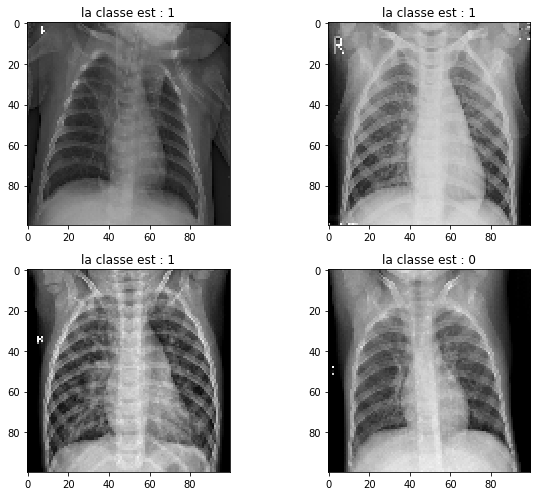

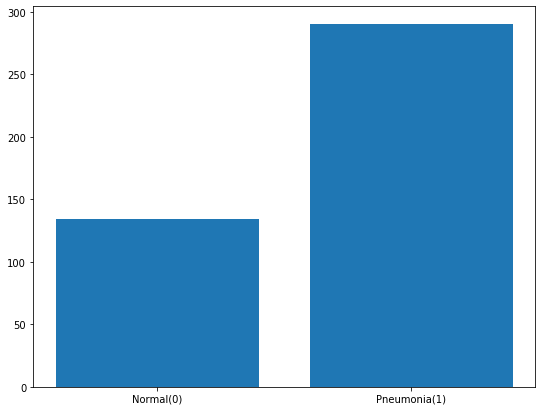

In [0]:
#In th following code we'll show 4 random examples of the x-ray images from the test set

fig, subfigs = pyplot.subplots(2, 2, tight_layout=True)
for subfig in subfigs.reshape(-1):
    
    #Choosing a random image
    index = numpy.random.randint(0,n )
    
    data,targets=test_set.__getitem__(index)
    #b=data.detach().numpy()
    #subfig = b[0][:][:]
    subfig.imshow(data[0], cmap="gray")
    

    subfig.title.set_text("la classe est : " + str(targets))

    
#In the following code we are creating bar graphs to show the number of images from the training test  
#that correspond to class 0 (Normal) and to class 1 (Pneumonia).    
    
fig, subfig = pyplot.subplots()
nb_zero = 0
nb_one = 0 
i = 0

for i in range(n):
    data,targets=test_set.__getitem__(i)
    
    if targets == 0:
        nb_zero += 1
    else:
        nb_one += 1 

        names = ["Normal(0)","Pneumonia(1)"]
        
values = [nb_zero, nb_one]
subfig.bar(names,values)

pyplot.show()

In [0]:
val_set=pneumoniaDataset("val", 100) #Creating a validation dataset of images with size 100x100 for visualization
n=val_set.__len__() #Getting the number of data from the validation set

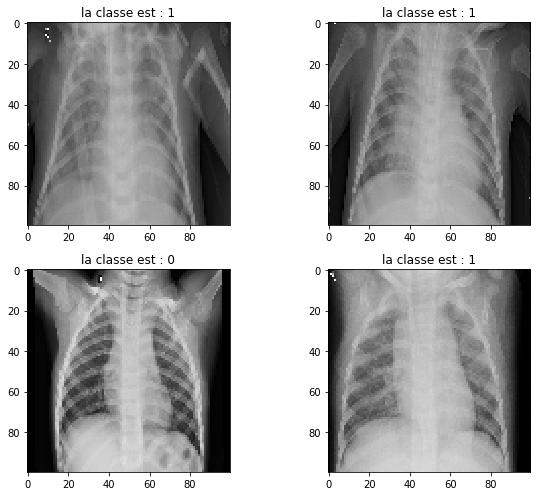

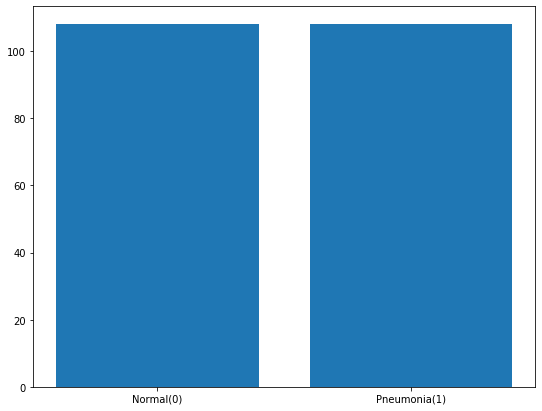

In [0]:
#In th following code we'll show 4 random examples of the x-ray images from the validation set

fig, subfigs = pyplot.subplots(2, 2, tight_layout=True)
for subfig in subfigs.reshape(-1):
    
    # Affichage des images aléatoires
    index = numpy.random.randint(0,n )
    
    data,targets=val_set.__getitem__(index)
    #b=data.detach().numpy()
    #subfig = b[0][:][:]
    subfig.imshow(data[0], cmap="gray")
    

    subfig.title.set_text("la classe est : " + str(targets))

    
#In the following code we are creating bar graphs to show the number of images from the training test  
#that correspond to class 0 (Normal) and to class 1 (Pneumonia).  

fig, subfig = pyplot.subplots()
nb_zero = 0
nb_one = 0 
i = 0



for i in range(n):
    data,targets=val_set.__getitem__(i)
    
    if targets == 0:
        nb_zero += 1
    else:
        nb_one += 1 

        names = ["Normal(0)","Pneumonia(1)"]
        
values = [nb_zero, nb_one]
subfig.bar(names,values)

pyplot.show()

# 5. Instantiating models, defining training and validation sets

In [0]:
#Instantiating models
model_resnet101 = Pneumonia_resnet101()
model_vgg16 = Pneumonia_vgg16()
model_densenet161 = Pneumonia_densenet161()

# Definig the validation and training image data, for different sizes.
val_set_128 = pneumoniaDataset("val", 128)
train_set_128 = pneumoniaDataset("train", 128)
val_set_256 = pneumoniaDataset("val", 256)
train_set_256 = pneumoniaDataset("train", 256)
val_set_512 = pneumoniaDataset("val", 512)
train_set_512 = pneumoniaDataset("train", 512)

# 6. Training step (10 epochs) and hyperparameter testing for all three models.

In [0]:
learning_rate_list = numpy.logspace(-3, 1, num=5) # We'll be using different learning rates [1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]
resultat_lr = []
resultat_acc = []
resultat_res = []

print("Resnet101, taille d'image 128")
for learning_rate in learning_rate_list:
    print("learning rate", learning_rate)
    max_acc = max(train(model=Pneumonia_resnet101(), train_set=train_set_128, test_set=val_set_128, learning_rate=learning_rate, nb_epoch=10))
    print("Précision max", max_acc)
    resultat_lr.append(learning_rate)
    resultat_acc.append(max_acc)
    resultat_res.append(128)

print("Resnet101, taille d'image 256")
for learning_rate in learning_rate_list:
    print("learning rate", learning_rate)
    max_acc = max(train(model=Pneumonia_resnet101(), train_set=train_set_256, test_set=val_set_256, learning_rate=learning_rate, nb_epoch=10))
    print("Précision max", max_acc)
    resultat_lr.append(learning_rate)
    resultat_acc.append(max_acc)
    resultat_res.append(256)

print("Resnet101, taille d'image 512")
for learning_rate in learning_rate_list:
    print("learning rate", learning_rate)
    max_acc = max(train(model=Pneumonia_resnet101(), train_set=train_set_512, test_set=val_set_512, learning_rate=learning_rate, nb_epoch=10))
    print("Précision max", max_acc)
    resultat_lr.append(learning_rate)
    resultat_acc.append(max_acc)
    resultat_res.append(512)

print("VGG16, taille d'image 128")
for learning_rate in learning_rate_list:
    print("learning rate", learning_rate)
    max_acc = max(train(model=Pneumonia_vgg16(), train_set=train_set_128, test_set=val_set_128, learning_rate=learning_rate, nb_epoch=10))
    print("Précision max", max_acc)
    resultat_lr.append(learning_rate)
    resultat_acc.append(max_acc)
    resultat_res.append(128)

print("VGG16, taille d'image 256")
for learning_rate in learning_rate_list:
    print("learning rate", learning_rate)
    max_acc = max(train(model=Pneumonia_vgg16(), train_set=train_set_256, test_set=val_set_256, learning_rate=learning_rate, nb_epoch=10))
    print("Précision max", max_acc)
    resultat_lr.append(learning_rate)
    resultat_acc.append(max_acc)
    resultat_res.append(256)

print("Densenet161, taille d'image 128")
for learning_rate in learning_rate_list:
    print("learning rate", learning_rate)
    max_acc = max(train(model=Pneumonia_densenet161(), train_set=train_set_128, test_set=val_set_128, learning_rate=learning_rate, nb_epoch=10))
    print("Précision max", max_acc)
    resultat_lr.append(learning_rate)
    resultat_acc.append(max_acc)
    resultat_res.append(128)

print("Densenet161, taille d'image 256")
for learning_rate in learning_rate_list:
    print("learning rate", learning_rate)
    max_acc = max(train(model=Pneumonia_densenet161(), train_set=train_set_256, test_set=val_set_256, learning_rate=learning_rate, nb_epoch=10))
    print("Précision max", max_acc)
    resultat_lr.append(learning_rate)
    resultat_acc.append(max_acc)
    resultat_res.append(256)





Resnet101, taille d'image 128
learning rate 0.001
 [-] epoch    1/10, train loss 0.353491 in 3.18s
 [-] test acc. 76.388889%
 [-] epoch    2/10, train loss 0.260642 in 3.16s
 [-] test acc. 75.000000%
 [-] epoch    3/10, train loss 0.241301 in 3.15s
 [-] test acc. 74.074074%
 [-] epoch    4/10, train loss 0.229858 in 3.17s
 [-] test acc. 72.222222%
 [-] epoch    5/10, train loss 0.221604 in 3.16s
 [-] test acc. 70.833333%
 [-] epoch    6/10, train loss 0.215082 in 3.16s
 [-] test acc. 69.907407%
 [-] epoch    7/10, train loss 0.209650 in 3.17s
 [-] test acc. 69.907407%
 [-] epoch    8/10, train loss 0.204969 in 3.16s
 [-] test acc. 69.907407%
 [-] epoch    9/10, train loss 0.200841 in 3.15s
 [-] test acc. 69.907407%
 [-] epoch   10/10, train loss 0.197139 in 3.16s
 [-] test acc. 68.981481%
 [-] test acc. 68.981481%
Précision max 0.7638888888888888
learning rate 0.01
 [-] epoch    1/10, train loss 0.512449 in 3.17s
 [-] test acc. 81.944444%
 [-] epoch    2/10, train loss 0.472897 in 3.16

In [0]:
print(max(resultat_acc)) #Highest accuracy (.875)
print(numpy.argmax(resultat_acc)) #Using RESNET-101, an image size of 256 and learning rate (lr) of 1.e-01=0.1
print(resultat_acc[7])
print(resultat_lr[7])
print(resultat_res[7])
#Even though we get an accuracy of .875 using a lr=0.1, the loss function value is about 2.83.
#The second best accuracy (.838), we get it when using a lr=0.01, the loss function value is less than
#when using a lr=0.1, which is loss=.2485. 
#So we'll proceed to train with more epochs the model with lr=0.01

0.875
7
0.875
0.1
256


# 7. Training step (60 epochs) using the best model between the three and with the best hyperparameters (resnet-101, lr=0.01, image size 256x256).

 [-] epoch    1/60, train loss 0.428828 in 10.23s
 [-] test acc. 71.296296%
 [-] epoch    2/60, train loss 0.302881 in 10.22s
 [-] test acc. 76.388889%
 [-] epoch    3/60, train loss 0.314224 in 10.23s
 [-] test acc. 84.259259%
 [-] epoch    4/60, train loss 0.255147 in 10.24s
 [-] test acc. 85.648148%
 [-] epoch    5/60, train loss 0.225780 in 10.23s
 [-] test acc. 85.648148%
 [-] epoch    6/60, train loss 0.212558 in 10.23s
 [-] test acc. 85.648148%
 [-] epoch    7/60, train loss 0.210986 in 10.23s
 [-] test acc. 85.648148%
 [-] epoch    8/60, train loss 0.223448 in 10.23s
 [-] test acc. 84.722222%
 [-] epoch    9/60, train loss 0.237615 in 10.23s
 [-] test acc. 85.648148%
 [-] epoch   10/60, train loss 0.225845 in 10.23s
 [-] test acc. 84.722222%
 [-] epoch   11/60, train loss 0.196016 in 10.23s
 [-] test acc. 84.722222%
 [-] epoch   12/60, train loss 0.176679 in 10.23s
 [-] test acc. 83.333333%
 [-] epoch   13/60, train loss 0.163713 in 10.24s
 [-] test acc. 83.796296%
 [-] epoch  

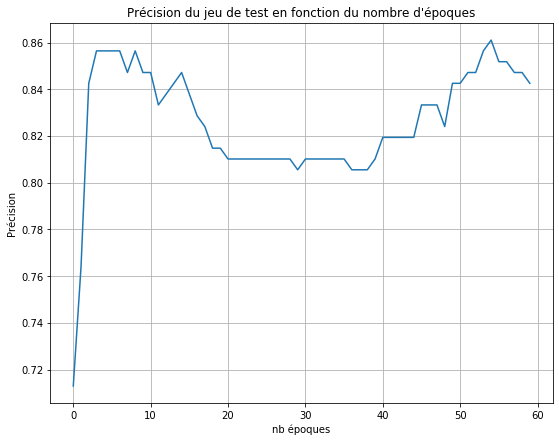

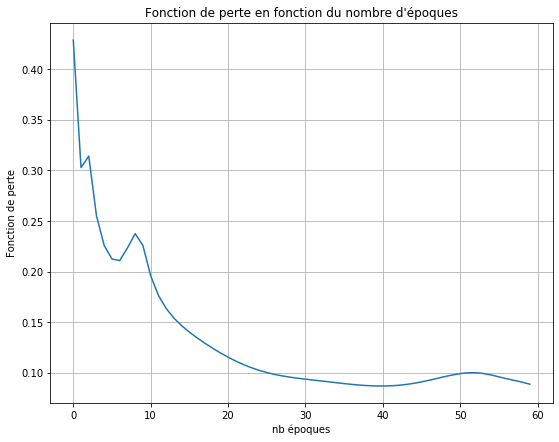

In [0]:
#We'll se if training with more epochs results in a higher accuracy...
torch.cuda.empty_cache()
model_choisi = Pneumonia_resnet101()

precisions = train(model_choisi, train_set=train_set_256, test_set=val_set_256, learning_rate=0.01, nb_epoch=60)
precision_max = max(precisions)
precision_max_arg = numpy.argmax(precisions)
print("Precision max : ", precision_max, "nb époques : ", (precision_max_arg+1))

# Accuracy en fonction du nombre d'époques
fig, ax = pyplot.subplots()
ax.plot(numpy.arange(len(precisions)), precisions)
ax.set(xlabel='nb époques', ylabel='Précision', title="Précision du jeu de test en fonction du nombre d'époques")
ax.grid()

pyplot.savefig('accuracy_epochs.png')

# Loss en fonction du nombre d'époques
#fig, ax = pyplot.subplots()
#ax.plot(numpy.arange(len(precisions)), losses)
#ax.set(xlabel='nb époques', ylabel='Fonction de perte', title="Fonction de perte en fonction du nombre d'époques")
#ax.grid()

#pyplot.savefig('loss_epochs.png')


# 8. Training step (9 epochs) using resnet-101, lr=0.01, image size 256x256.¶

In [0]:
#From the previous graph (accuracy vs epochs for validation set) we can see that training with a lot of epochs
#doesn' mean we'll get a higher accuracy on the validation set. In fact we can see that the accuracy goes up and down. 
#This is because the model will overfit at certain epochs, or learn by heart every training data, so it wont' be able to generalize.
#We can see that the model reaches a good accuracy for 9 epochs, so we'll train again our model for 9 epochs.

torch.cuda.empty_cache()

model_final = Pneumonia_resnet101()
precisions2 = train(model_final, train_set=train_set_256, test_set=val_set_256, learning_rate=0.01, nb_epoch=9)

 [-] epoch    1/9, train loss 0.407543 in 10.26s
 [-] test acc. 76.851852%
 [-] epoch    2/9, train loss 0.270581 in 10.25s
 [-] test acc. 76.851852%
 [-] epoch    3/9, train loss 0.238444 in 10.25s
 [-] test acc. 78.240741%
 [-] epoch    4/9, train loss 0.229874 in 10.25s
 [-] test acc. 81.481481%
 [-] epoch    5/9, train loss 0.224007 in 10.25s
 [-] test acc. 83.333333%
 [-] epoch    6/9, train loss 0.205922 in 10.25s
 [-] test acc. 83.796296%
 [-] epoch    7/9, train loss 0.184971 in 10.25s
 [-] test acc. 83.796296%
 [-] epoch    8/9, train loss 0.169887 in 10.25s
 [-] test acc. 83.333333%
 [-] epoch    9/9, train loss 0.158607 in 10.25s
 [-] test acc. 83.796296%
 [-] test acc. 83.796296%
[0.4075425948399159, 0.2705808136657886, 0.2384436578129881, 0.22987376604846285, 0.22400674818117924, 0.2059221629430454, 0.1849708505306233, 0.1698869998492529, 0.15860690408460568]


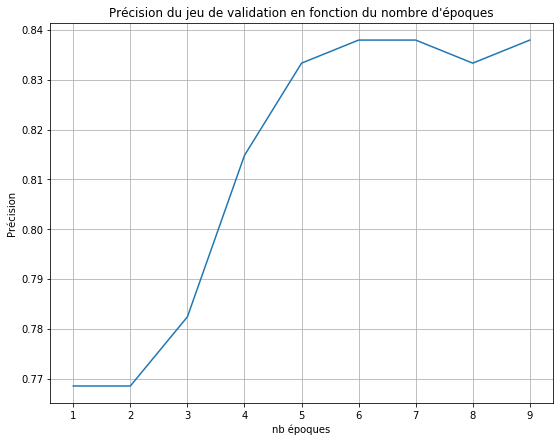

In [0]:
# Accuracy vs epoch
fig, ax = pyplot.subplots()
ax.plot(numpy.arange(1,10), precisions2)
ax.set(xlabel='nb époques', ylabel='Précision', title="Précision du jeu de validation en fonction du nombre d'époques")
ax.grid()

pyplot.savefig('accuracy_final_epochs.png')

# 9. Computing accuracy on the training set


In [1]:
train_loader = DataLoader(train_set_256, batch_size=32)
device = "cuda"
train_acc = compute_accuracy(model_final, train_loader, device)
print(' [-] train acc. {:.6f}%'.format(train_acc * 100))

 [-] train acc. 92.312117%


# 10. Computing accuracy on the test set

In [0]:
test_set = pneumoniaDataset("test", 256)
test_loader = DataLoader(test_set, batch_size=32)
device = "cuda"
test_acc = compute_accuracy(model_final, test_loader, device)
print(' [-] test acc. {:.6f}%'.format(test_acc * 100))

 [-] test acc. 89.622642%


# 11. Computing confusion matrix

In [0]:
matrix = compute_confusion_matrix(model_final, test_loader, device='cuda')
print(matrix)

[[106, 28], [16, 274]]
